**Basic setup block**


*   Load the required utils/libraries
*   Setup the transformations needed to load the data
*   Split the input data into train and test
*   Create the train and test data objects





In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, utils
%matplotlib inline
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
!pip install torchsummary
from torchsummary import summary
import numpy as np

In [ ]:
!pip install -U albumentations
import albumentations as A
import cv2


import albumentations as A
from albumentations.pytorch import ToTensorV2

     |████████████████████████████████| 102kB 6.3MB/s 
     |████████████████████████████████| 38.2MB 88kB/s 
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [ ]:
test_transforms  = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.4914,0.4822,0.4465), (0.247,0.2435,0.2616))
                                      ])

In [ ]:
train_transforms_a = A.Compose([
                                       A.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.2435, 0.2616)),
                                       A.HorizontalFlip(p=0.5),
                                       A.ShiftScaleRotate(),
                                       A.CoarseDropout(max_holes=1,max_height=16,max_width=16,min_holes=1,min_height=16,min_width=16,fill_value=(0.4914, 0.4822, 0.4465),mask_fill_value=None),
                                       ToTensorV2()
                                       ])

In [ ]:
import cv2
import torchvision

##copied from albumentations.io
cv2.setNumThreads(0)
cv2.ocl.setUseOpenCL(False)

class data_albumentations(datasets.CIFAR10):
    def __init__(self, root="~/data/cifar10", train=True, download=True, transform=None):
        super().__init__(root=root, train=train, download=download, transform=transform)

    def __getitem__(self, index):
        image, label = self.data[index], self.targets[index]

        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]

        return image, label



In [ ]:
#train = datasets.CIFAR10('./data', train=True,  download=True, transform=train_transforms)
train = data_albumentations(train=True,  download=True, transform=train_transforms_a)
test =  datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)



Extracting /root/data/cifar10/cifar-10-python.tar.gz to /root/data/cifar10



Extracting ./data/cifar-10-python.tar.gz to ./data


In [ ]:
#Always start with same random set everytime
SEED = 1

#Is GPU ?
cuda = torch.cuda.is_available()

print('CUDA Available?',cuda)

#what happens when SEED = 2 ?
torch.manual_seed(SEED)

#set the seed for GPU device as well
if cuda:
  torch.cuda.manual_seed(SEED)

device = torch.device("cuda" if cuda else "cpu")
print(device)

dataloader_args = dict(shuffle=True, batch_size=128, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)
#Why change batch_size for CPU - since it should not matter

train_loader = torch.utils.data.DataLoader(train, **dataloader_args)


test_loader  = torch.utils.data.DataLoader(test, **dataloader_args)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

##Why shuffle=false in the example provided ?

CUDA Available? True
cuda


**Visualize the input data with image standardization**


In [ ]:
image_loader = torch.utils.data.DataLoader(train, shuffle=True,batch_size=4)

def imshow(img):
    npimg = img.numpy()
    npimg[0] = (npimg[0] * 0.247) + 0.4914
    npimg[1] = (npimg[1] * 0.2435) + 0.4822
    npimg[2] = (npimg[2] * 0.2616) + 0.4465
    #we can use this directly but simply converting to tensor and converting back
    timg = torch.from_numpy(npimg)
    nimg = timg.numpy()
    plt.imshow(np.transpose(nimg, (1, 2, 0)))

# get some random training images
dataiter = iter(image_loader)
images, labels = dataiter.next()

# show images
#imshow(torchvision.utils.make_grid(images))
#print(classes[labels[10]])
#print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

**Visualize the input data without image standardization**



In [ ]:
#Comment this block from CODE2 onwards
train_nonorm_transforms = transforms.Compose([
                                       transforms.ToTensor()
                                       #transforms.Normalize((0.1307,), (0.3081,))
                                       #transforms.RandomRotation((-7.0,7.0),fill=(0,)), #Ideally use mean - adding #0 since MNIST dark pixels and no-information around the borders
                                       #transforms.ColorJitter(brightness = 0.1, contrast= 0.1, saturation = 0.1, hue =0.1),
                                       #transforms.Resize((28,28)) #should be before converting to Tensor logically
                                       ])
test_nonorm_transforms  = transforms.Compose([
                                       transforms.ToTensor()
                                       #transforms.Normalize((0.1307,), (0.3081,))
                                       #transforms.RandomRotation((-7.0,7.0),fill=(0,)), #Ideally use mean - adding #0 since MNIST dark pixels and no-information around the borders
                                       #transforms.ColorJitter(brightness = 0.1, contrast= 0.1, saturation = 0.1, hue =0.1)
                                       #transforms.Resize((28,28)) #should be before converting to Tensor logically
                                      ])
train_nonorm = datasets.CIFAR10('./data_nonorm', train=True,  download=True, transform=train_nonorm_transforms)
test_nonorm =  datasets.CIFAR10('./data_nonorm', train=False, download=True, transform=test_nonorm_transforms)
train_loader_nonorm = torch.utils.data.DataLoader(train_nonorm, **dataloader_args)
test_loader_nonorm  = torch.utils.data.DataLoader(test_nonorm, **dataloader_args)


Extracting ./data_nonorm/cifar-10-python.tar.gz to ./data_nonorm
Files already downloaded and verified


In [ ]:
#chsum = 0
##pbar = tqdm(train_loader_nonorm)

#for index, (data,target) in enumerate(train_loader_nonorm):
#    chsum += data.sum(dim=(0,2,3),keepdim=True)

#mean = chsum / (len(train_nonorm) * 32 *32)
#
#chsum = None
#for index, (data,target) in enumerate(train_loader_nonorm):
#  if index == 0:
#   print(data.min(),data.max())
#   chsum = (data - mean).pow(2).sum(dim=(0,2,3),keepdim=True)
#  else:
#   chsum += (data - mean).pow(2).sum(dim=(0,2,3),keepdim=True)

#std = torch.sqrt(chsum/(len(train_nonorm) * 32 * 32))
#print("Traindata Mean",mean)
#print("Traindata std dev",std)

#chsum = 0

#for index, (data,target) in enumerate(test_loader_nonorm):
#    chsum += data.sum(dim=(0,2,3),keepdim=True)

#mean = chsum / (len(test_nonorm) * 32 *32)

#chsum = None
#for index, (data,target) in enumerate(test_loader_nonorm):
#  if index == 0:
#    chsum = (data - mean).pow(2).sum(dim=(0,2,3),keepdim=True)
#  else:
#   chsum += (data - mean).pow(2).sum(dim=(0,2,3),keepdim=True)

#std = torch.sqrt(chsum/(len(test_nonorm) * 32 * 32))
#print("Test data Mean",mean)
#print("Test data std dev",std)

ship


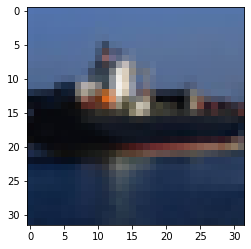

In [ ]:
dataiter = iter(train_loader_nonorm)
images, labels = dataiter.next()

def imshow_nonorm(img):
    img = img     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
# show images
imshow_nonorm(torchvision.utils.make_grid(images[10]))

print(classes[labels[10]])
#print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

**####Batch Normalization + L1 LOSS**

In [ ]:
dropout_perc = 0.05

class BatchNormNet(nn.Module):
    def __init__(self):
        super(BatchNormNet, self).__init__()

        #BLOCK C1
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=1, dilation = 1,bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(dropout_perc)
        ) 

        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, dilation = 1,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_perc)
        ) 
        
       #BLOCK C1 TRANSITION
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
        ) 

        #self.pool1 = nn.MaxPool2d(2, 2) # output_size = 16 ; #Receptive field = 8x8
        #Drop maxPooling and use strided convolution
        self.pool1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=2, padding=1, dilation =1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_perc)
        )
        #Use dilated kernels instead of Max pooling / stride =2 conv
        self.pool1_dilation = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, groups = 32 , kernel_size=(3, 3), dilation=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_perc),
            nn.Conv2d(in_channels=64, out_channels=128, groups = 64 ,kernel_size=(3, 3), dilation=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_perc),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=(1, 1), padding=0, bias=False)
        )
        #BLOCK C2
        
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, groups = 64, kernel_size=(3, 3), padding=1, dilation = 2 ,bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_perc)
        )
        
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, groups = 128, kernel_size=(3, 3), padding=1, dilation =2, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(dropout_perc)
        )

       
        #BLOCK C2 TRANSITION
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
        )
             

        
        #self.pool2 = nn.MaxPool2d(2, 2) # output_size = 8 ; #Receptive field = 8x8
        self.pool2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=2, padding=1, dilation = 1,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_perc)
        )
        self.pool2_dilation = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, groups = 32, kernel_size=(3, 3), padding=1, dilation =2,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_perc),
            nn.Conv2d(in_channels=64, out_channels=128, groups = 64, kernel_size=(3, 3), padding=1, dilation =2,bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_perc),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=(1, 1), padding=0,bias=False)
        )

        #BLOCK C3

     
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, groups = 64, kernel_size=(3, 3), padding=1, dilation =2,bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_perc)
        )
        
        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, groups = 128, kernel_size=(3, 3), padding=1, dilation=2 , bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(dropout_perc)
        ) 

        #BLOCK C3 TRANSITION
        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
        ) 
        
        #self.pool2 = nn.MaxPool2d(2, 2) # output_size = 8 ; #Receptive field = 8x8
        self.pool3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=2, padding=1, dilation = 1,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_perc)
        )
        
        self.pool3_dilation = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, groups=32 , kernel_size=(3, 3), padding=1, dilation = 2,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_perc)
        )
        #BLOCK C4
        
        
        self.convblock11 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, groups = 64, kernel_size=(3, 3), padding=1, dilation=2 , bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_perc)
        ) 
        
        self.convblock12 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, groups = 128 , kernel_size=(3, 3), padding=1, dilation =2,bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(dropout_perc)
        )

        self.convblock25 = nn.Sequential(
            nn.Conv2d(in_channels=256, groups = 256, out_channels=512, kernel_size=(3, 3), padding=1, dilation=2, bias=False)
        ) 

                 
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=8)
        ) # output_size = 1

        self.convblock13 = nn.Sequential(
            nn.Linear(512,10,0)
        )

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock4(x)
        
        #x = self.pool1(x)
        x = self.pool1_dilation(x)
        
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)

        #x = self.pool2(x)
        x = self.pool2_dilation(x)

        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.convblock10(x)

        #x = self.pool3(x)
        x = self.pool3_dilation(x)
        
        x = self.convblock11(x)
        x = self.convblock12(x)
        x = self.convblock25(x)
        x = self.gap(x)
        
        x = x.view(x.size(0), -1)
        x = self.convblock13(x)
   
        return F.log_softmax(x, dim=-1)

In [ ]:
model = BatchNormNet().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          18,432
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
           Dropout-8           [-1, 64, 32, 32]               0
            Conv2d-9           [-1, 32, 32, 32]           2,048
           Conv2d-10           [-1, 64, 30, 30]             576
      BatchNorm2d-11           [-1, 64, 30, 30]             128
             ReLU-12           [-1, 64, 30, 30]               0
          Dropout-13           [-1, 64, 30, 30]               0
           Conv2d-14          [-1, 128,

####LayerNorm Normalization + L1 LOSS

**`####Group normalization network + L1 LOSS`**

In [ ]:
from tqdm import tqdm

test_fail_data = []
test_fail_target = []
test_pred_target = []
test_losses = []
test_acc = []
train_acc = []
train_losses = []

loss_function = nn.CrossEntropyLoss()

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)

  l1_lamda = 0.0001
  
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    #Cross entropy loss
    #loss = F.nll_loss(y_pred, target)
    loss = loss_function(y_pred,target)
    #

    ##Add L1 Loss
    l1 = 0
    for p in model.parameters():
      p_tensor = torch.sum(torch.abs(p))
      l1 += p_tensor

    loss = loss + l1_lamda * l1
    
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    test_fail_data = []
    test_fail_target = []
    test_pred_target = []

    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            #print(pred,target.view_as(pred))
            correct += pred.eq(target.view_as(pred)).sum().item()
            for i,x in enumerate(pred.eq(target.view_as(pred))):
              if not x:
                test_fail_data.append(data[i])
                test_fail_target.append(target[i])
                test_pred_target.append(pred[i])
                #print(target[i])

    test_losses.append(test_loss)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

    return test_losses, test_acc, test_fail_data, test_fail_target, test_pred_target;

**####Block to pass argment and call the Model**

Pass the model to be Invoked based on Input Argument

In [ ]:
def main(input_model_type,EPOCHS):
  if input_model_type == 0:
    model = BatchNormNet().to(device)
    test_10_images, test_10_images_target , test_10_pred_target = run_train_test(model,EPOCHS,input_model_type)
    return test_10_images, test_10_images_target , test_10_pred_target ;
  elif input_model_type == 1:
    model = LayerNormNet().to(device)
    test_10_images, test_10_images_target , test_10_pred_target = run_train_test(model,EPOCHS,input_model_type)
    return test_10_images, test_10_images_target , test_10_pred_target ;
  elif input_model_type == 2:
    model = GroupNormNet().to(device)
    test_10_images, test_10_images_target , test_10_pred_target = run_train_test(model,EPOCHS,input_model_type)
    return test_10_images, test_10_images_target , test_10_pred_target ;
  else:
    print("Invalid input for input_model_type",input_model_type)
    print("Supported values are 0 = Batch Norm,1 = Layer Norm,2 = Group Norm")

def run_train_test(model,EPOCHS,input_model_type):
  #summary(model, input_size=(3, 32, 32))
  optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.9)
  scheduler = optim.lr_scheduler.StepLR(optimizer,step_size=10, gamma=0.7)

  for epoch in range(EPOCHS):
    #print("EPOCH:", epoch)
         
    print('Epoch {}, lr {}'.format(
        epoch, optimizer.param_groups[0]['lr']))
    
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test_losses, test_acc, test_fail_data, test_fail_target, test_pred_target = test(model, device, test_loader)
  
  #print(test_fail_data)
  fig, axs = plt.subplots(1, 2)
  if input_model_type == 0:
    fig.suptitle('Model Type: Batch normalization')
  if input_model_type == 1:
    fig.suptitle('Model Type: Layer normalization')
  if input_model_type == 2:
    fig.suptitle('Model Type: Group normalization')
  
  axs[0].set_title('Test/Validation Loss Graph')
  axs[0].set_xticks(np.arange(1,EPOCHS+1))
  #axs[0].xlabel('Test/Validation Loss Graph')
  #axs[0].ylabel('LOSS')
  axs[1].set_title('Test/Validation Accuracy Graph')
  axs[1].set_xticks(np.arange(1,EPOCHS+1))
  #axs[1].xlabel('Test/Validation Accuracy Graph')
  #axs[1].ylabel('Accuracy')
  
  axs[0].plot(test_losses)
  axs[1].plot(test_acc)

  test_10_images = []
  for i in range(0,10):
    test_10_images.append(test_fail_data[i])
  
  test_10_images_target = []
  for i in range(0,10):
    test_10_images_target.append(test_fail_target[i])

  test_10_pred_target = []
  for i in range(0,10):
    test_10_pred_target.append(test_pred_target[i])
  #print(test_10_images_target)

  print('Actual Labels')
  print(' '.join('%5s' % classes[test_10_images_target[j]] for j in range(0,10)))
  print('Predicted Labels')
  print(' '.join('%5s' % classes[test_10_pred_target[j]] for j in range(0,10)))

  test_10_images_unnorm = []
  for img in test_10_images:
    img = img.cpu()
    img = img.numpy()
    img[0] = img[0] * 0.247 + 0.4914
    img[1] = img[1] * 0.2435 + 0.4822
    img[2] = img[2] * 0.2616 + 0.4465

    img = torch.from_numpy(img)
    test_10_images_unnorm.append(img)
  
  grid = torchvision.utils.make_grid(torch.stack(test_10_images_unnorm).cpu(), nrow=5)
  plt.figure(figsize=(5,5))
  plt.imshow(np.transpose(grid, (1,2,0)))

  return test_10_images, test_10_images_target , test_10_pred_target;

**####Call to main function**

main(input_model_type,EPOCHS)

input_model_type:

Supported values are

0 = Train a model with Batch normalization

1 = Train a model with Layer normalization

2 = Train a model with Group Normalization

EPOCHS: num_epochs


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch 0, lr 0.02


Loss=2.2334890365600586 Batch_id=390 Accuracy=33.98: 100%|██████████| 391/391 [00:30<00:00, 12.93it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 14014.0897, Accuracy: 4950/10000 (49.50%)

Epoch 1, lr 0.02


Loss=1.8739376068115234 Batch_id=390 Accuracy=49.70: 100%|██████████| 391/391 [00:30<00:00, 12.67it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 10744.6139, Accuracy: 6161/10000 (61.61%)

Epoch 2, lr 0.02


Loss=2.0238068103790283 Batch_id=390 Accuracy=55.13: 100%|██████████| 391/391 [00:31<00:00, 12.39it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 10260.6797, Accuracy: 6337/10000 (63.37%)

Epoch 3, lr 0.02


Loss=1.912541151046753 Batch_id=390 Accuracy=58.79: 100%|██████████| 391/391 [00:31<00:00, 12.25it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 9458.2873, Accuracy: 6657/10000 (66.57%)

Epoch 4, lr 0.02


Loss=1.8190727233886719 Batch_id=390 Accuracy=60.99: 100%|██████████| 391/391 [00:31<00:00, 12.26it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 8780.2724, Accuracy: 6892/10000 (68.92%)

Epoch 5, lr 0.02


Loss=1.5833524465560913 Batch_id=390 Accuracy=62.31: 100%|██████████| 391/391 [00:31<00:00, 12.26it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 8597.2289, Accuracy: 7001/10000 (70.01%)

Epoch 6, lr 0.02


Loss=1.6508119106292725 Batch_id=390 Accuracy=63.46: 100%|██████████| 391/391 [00:31<00:00, 12.25it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 8432.2591, Accuracy: 7099/10000 (70.99%)

Epoch 7, lr 0.02


Loss=1.5546343326568604 Batch_id=390 Accuracy=64.58: 100%|██████████| 391/391 [00:31<00:00, 12.26it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 9020.1986, Accuracy: 6874/10000 (68.74%)

Epoch 8, lr 0.02


Loss=1.4471509456634521 Batch_id=390 Accuracy=65.74: 100%|██████████| 391/391 [00:31<00:00, 12.24it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 7286.7871, Accuracy: 7492/10000 (74.92%)

Epoch 9, lr 0.02


Loss=1.518886923789978 Batch_id=390 Accuracy=66.29: 100%|██████████| 391/391 [00:31<00:00, 12.27it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 7941.9623, Accuracy: 7239/10000 (72.39%)

Epoch 10, lr 0.013999999999999999


Loss=1.4232217073440552 Batch_id=390 Accuracy=68.07: 100%|██████████| 391/391 [00:31<00:00, 12.24it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 7302.2811, Accuracy: 7486/10000 (74.86%)

Epoch 11, lr 0.013999999999999999


Loss=1.5043203830718994 Batch_id=390 Accuracy=68.73: 100%|██████████| 391/391 [00:31<00:00, 12.25it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 6694.6562, Accuracy: 7670/10000 (76.70%)

Epoch 12, lr 0.013999999999999999


Loss=1.4876837730407715 Batch_id=390 Accuracy=69.10: 100%|██████████| 391/391 [00:31<00:00, 12.23it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 7181.2722, Accuracy: 7508/10000 (75.08%)

Epoch 13, lr 0.013999999999999999


Loss=1.2331691980361938 Batch_id=390 Accuracy=69.36: 100%|██████████| 391/391 [00:31<00:00, 12.25it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 6786.3679, Accuracy: 7662/10000 (76.62%)

Epoch 14, lr 0.013999999999999999


Loss=1.3476924896240234 Batch_id=390 Accuracy=69.81: 100%|██████████| 391/391 [00:31<00:00, 12.25it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 6953.9924, Accuracy: 7593/10000 (75.93%)

Epoch 15, lr 0.013999999999999999


Loss=1.3405976295471191 Batch_id=390 Accuracy=70.05: 100%|██████████| 391/391 [00:31<00:00, 12.25it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 6719.4708, Accuracy: 7708/10000 (77.08%)

Epoch 16, lr 0.013999999999999999


Loss=1.336604118347168 Batch_id=390 Accuracy=70.09: 100%|██████████| 391/391 [00:31<00:00, 12.24it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 7132.0863, Accuracy: 7595/10000 (75.95%)

Epoch 17, lr 0.013999999999999999


Loss=1.2441480159759521 Batch_id=390 Accuracy=70.46: 100%|██████████| 391/391 [00:31<00:00, 12.25it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 6604.7301, Accuracy: 7700/10000 (77.00%)

Epoch 18, lr 0.013999999999999999


Loss=1.3625802993774414 Batch_id=390 Accuracy=70.51: 100%|██████████| 391/391 [00:31<00:00, 12.22it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 6720.6045, Accuracy: 7663/10000 (76.63%)

Epoch 19, lr 0.013999999999999999


Loss=1.1627744436264038 Batch_id=390 Accuracy=70.78: 100%|██████████| 391/391 [00:31<00:00, 12.24it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 6359.2154, Accuracy: 7848/10000 (78.48%)

Epoch 20, lr 0.009799999999999998


Loss=1.1430270671844482 Batch_id=390 Accuracy=72.03: 100%|██████████| 391/391 [00:31<00:00, 12.24it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5946.7500, Accuracy: 7935/10000 (79.35%)

Epoch 21, lr 0.009799999999999998


Loss=1.4150035381317139 Batch_id=390 Accuracy=72.31: 100%|██████████| 391/391 [00:31<00:00, 12.23it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 6484.1215, Accuracy: 7775/10000 (77.75%)

Epoch 22, lr 0.009799999999999998


Loss=1.327547311782837 Batch_id=390 Accuracy=72.52: 100%|██████████| 391/391 [00:32<00:00, 12.22it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5589.5900, Accuracy: 8062/10000 (80.62%)

Epoch 23, lr 0.009799999999999998


Loss=1.3854845762252808 Batch_id=390 Accuracy=72.37: 100%|██████████| 391/391 [00:31<00:00, 12.23it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5667.4433, Accuracy: 8040/10000 (80.40%)

Epoch 24, lr 0.009799999999999998


Loss=1.2931418418884277 Batch_id=390 Accuracy=72.90: 100%|██████████| 391/391 [00:31<00:00, 12.23it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5908.8737, Accuracy: 7987/10000 (79.87%)

Epoch 25, lr 0.009799999999999998


Loss=1.1837102174758911 Batch_id=390 Accuracy=72.77: 100%|██████████| 391/391 [00:31<00:00, 12.23it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5718.6923, Accuracy: 8053/10000 (80.53%)

Epoch 26, lr 0.009799999999999998


Loss=1.1145291328430176 Batch_id=390 Accuracy=72.63: 100%|██████████| 391/391 [00:31<00:00, 12.23it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5679.5509, Accuracy: 8044/10000 (80.44%)

Epoch 27, lr 0.009799999999999998


Loss=1.4165735244750977 Batch_id=390 Accuracy=73.11: 100%|██████████| 391/391 [00:31<00:00, 12.23it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5601.5218, Accuracy: 8076/10000 (80.76%)

Epoch 28, lr 0.009799999999999998


Loss=1.3322458267211914 Batch_id=390 Accuracy=72.85: 100%|██████████| 391/391 [00:31<00:00, 12.23it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5561.9864, Accuracy: 8093/10000 (80.93%)

Epoch 29, lr 0.009799999999999998


Loss=1.337112545967102 Batch_id=390 Accuracy=73.06: 100%|██████████| 391/391 [00:32<00:00, 12.19it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5629.8288, Accuracy: 8064/10000 (80.64%)

Epoch 30, lr 0.006859999999999998


Loss=1.319724678993225 Batch_id=390 Accuracy=74.02: 100%|██████████| 391/391 [00:31<00:00, 12.23it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5409.0018, Accuracy: 8134/10000 (81.34%)

Epoch 31, lr 0.006859999999999998


Loss=1.3134407997131348 Batch_id=390 Accuracy=74.25: 100%|██████████| 391/391 [00:32<00:00, 12.21it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5223.4649, Accuracy: 8219/10000 (82.19%)

Epoch 32, lr 0.006859999999999998


Loss=1.1561541557312012 Batch_id=390 Accuracy=74.33: 100%|██████████| 391/391 [00:31<00:00, 12.22it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4981.4879, Accuracy: 8274/10000 (82.74%)

Epoch 33, lr 0.006859999999999998


Loss=1.1797142028808594 Batch_id=390 Accuracy=74.58: 100%|██████████| 391/391 [00:31<00:00, 12.22it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5083.3199, Accuracy: 8232/10000 (82.32%)

Epoch 34, lr 0.006859999999999998


Loss=1.2072968482971191 Batch_id=390 Accuracy=74.40: 100%|██████████| 391/391 [00:31<00:00, 12.24it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5007.5388, Accuracy: 8268/10000 (82.68%)

Epoch 35, lr 0.006859999999999998


Loss=1.0960078239440918 Batch_id=390 Accuracy=74.44: 100%|██████████| 391/391 [00:32<00:00, 12.21it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5500.0220, Accuracy: 8139/10000 (81.39%)

Epoch 36, lr 0.006859999999999998


Loss=1.1398820877075195 Batch_id=390 Accuracy=74.75: 100%|██████████| 391/391 [00:32<00:00, 12.22it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5855.9122, Accuracy: 8002/10000 (80.02%)

Epoch 37, lr 0.006859999999999998


Loss=1.2102560997009277 Batch_id=390 Accuracy=75.05: 100%|██████████| 391/391 [00:31<00:00, 12.22it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5328.9911, Accuracy: 8159/10000 (81.59%)

Epoch 38, lr 0.006859999999999998


Loss=1.1144367456436157 Batch_id=390 Accuracy=74.78: 100%|██████████| 391/391 [00:31<00:00, 12.22it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5066.5439, Accuracy: 8254/10000 (82.54%)

Epoch 39, lr 0.006859999999999998


Loss=1.180842399597168 Batch_id=390 Accuracy=74.97: 100%|██████████| 391/391 [00:31<00:00, 12.22it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5414.1904, Accuracy: 8109/10000 (81.09%)

Epoch 40, lr 0.004801999999999998


Loss=1.24506413936615 Batch_id=390 Accuracy=75.69: 100%|██████████| 391/391 [00:32<00:00, 12.21it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4973.9215, Accuracy: 8322/10000 (83.22%)

Epoch 41, lr 0.004801999999999998


Loss=1.0381488800048828 Batch_id=390 Accuracy=75.49: 100%|██████████| 391/391 [00:32<00:00, 12.22it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5114.3654, Accuracy: 8267/10000 (82.67%)

Epoch 42, lr 0.004801999999999998


Loss=1.2411073446273804 Batch_id=390 Accuracy=75.87: 100%|██████████| 391/391 [00:32<00:00, 12.22it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4940.8785, Accuracy: 8281/10000 (82.81%)

Epoch 43, lr 0.004801999999999998


Loss=1.1732804775238037 Batch_id=390 Accuracy=75.62: 100%|██████████| 391/391 [00:32<00:00, 12.20it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4763.3384, Accuracy: 8353/10000 (83.53%)

Epoch 44, lr 0.004801999999999998


Loss=1.0084887742996216 Batch_id=390 Accuracy=76.13: 100%|██████████| 391/391 [00:32<00:00, 12.21it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4720.0895, Accuracy: 8342/10000 (83.42%)

Epoch 45, lr 0.004801999999999998


Loss=1.1460850238800049 Batch_id=390 Accuracy=75.77: 100%|██████████| 391/391 [00:32<00:00, 12.21it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5055.8283, Accuracy: 8289/10000 (82.89%)

Epoch 46, lr 0.004801999999999998


Loss=1.24497389793396 Batch_id=390 Accuracy=76.13: 100%|██████████| 391/391 [00:32<00:00, 12.21it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 5148.3343, Accuracy: 8276/10000 (82.76%)

Epoch 47, lr 0.004801999999999998


Loss=1.20677649974823 Batch_id=390 Accuracy=76.02: 100%|██████████| 391/391 [00:32<00:00, 12.20it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4984.1642, Accuracy: 8287/10000 (82.87%)

Epoch 48, lr 0.004801999999999998


Loss=1.090759038925171 Batch_id=390 Accuracy=76.33: 100%|██████████| 391/391 [00:32<00:00, 12.20it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4795.5253, Accuracy: 8366/10000 (83.66%)

Epoch 49, lr 0.004801999999999998


Loss=1.1639764308929443 Batch_id=390 Accuracy=76.07: 100%|██████████| 391/391 [00:32<00:00, 12.19it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4752.8746, Accuracy: 8373/10000 (83.73%)

Epoch 50, lr 0.0033613999999999983


Loss=0.9143306016921997 Batch_id=390 Accuracy=76.58: 100%|██████████| 391/391 [00:32<00:00, 12.20it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4671.5366, Accuracy: 8414/10000 (84.14%)

Epoch 51, lr 0.0033613999999999983


Loss=1.0281248092651367 Batch_id=390 Accuracy=77.16: 100%|██████████| 391/391 [00:32<00:00, 12.20it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4614.5259, Accuracy: 8392/10000 (83.92%)

Epoch 52, lr 0.0033613999999999983


Loss=1.0589286088943481 Batch_id=390 Accuracy=77.06: 100%|██████████| 391/391 [00:32<00:00, 12.20it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4759.2670, Accuracy: 8370/10000 (83.70%)

Epoch 53, lr 0.0033613999999999983


Loss=1.290137767791748 Batch_id=390 Accuracy=77.09: 100%|██████████| 391/391 [00:32<00:00, 12.20it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4871.9514, Accuracy: 8328/10000 (83.28%)

Epoch 54, lr 0.0033613999999999983


Loss=1.1535460948944092 Batch_id=390 Accuracy=76.69: 100%|██████████| 391/391 [00:31<00:00, 12.22it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4856.5292, Accuracy: 8329/10000 (83.29%)

Epoch 55, lr 0.0033613999999999983


Loss=1.0615350008010864 Batch_id=390 Accuracy=77.44: 100%|██████████| 391/391 [00:32<00:00, 12.16it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4884.6515, Accuracy: 8321/10000 (83.21%)

Epoch 56, lr 0.0033613999999999983


Loss=1.140975832939148 Batch_id=390 Accuracy=76.94: 100%|██████████| 391/391 [00:32<00:00, 12.18it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4805.2994, Accuracy: 8365/10000 (83.65%)

Epoch 57, lr 0.0033613999999999983


Loss=1.0803139209747314 Batch_id=390 Accuracy=77.27: 100%|██████████| 391/391 [00:32<00:00, 12.17it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4560.4489, Accuracy: 8426/10000 (84.26%)

Epoch 58, lr 0.0033613999999999983


Loss=1.4211424589157104 Batch_id=390 Accuracy=77.09: 100%|██████████| 391/391 [00:32<00:00, 12.20it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4564.8666, Accuracy: 8437/10000 (84.37%)

Epoch 59, lr 0.0033613999999999983


Loss=0.9685736298561096 Batch_id=390 Accuracy=77.17: 100%|██████████| 391/391 [00:32<00:00, 12.19it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4550.0801, Accuracy: 8449/10000 (84.49%)

Epoch 60, lr 0.002352979999999999


Loss=1.074831247329712 Batch_id=390 Accuracy=77.66: 100%|██████████| 391/391 [00:32<00:00, 12.19it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4523.9911, Accuracy: 8465/10000 (84.65%)

Epoch 61, lr 0.002352979999999999


Loss=1.105080008506775 Batch_id=390 Accuracy=77.87: 100%|██████████| 391/391 [00:32<00:00, 12.17it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4380.5986, Accuracy: 8516/10000 (85.16%)

Epoch 62, lr 0.002352979999999999


Loss=1.044072151184082 Batch_id=390 Accuracy=77.88: 100%|██████████| 391/391 [00:32<00:00, 12.19it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4487.9363, Accuracy: 8489/10000 (84.89%)

Epoch 63, lr 0.002352979999999999


Loss=0.9859446287155151 Batch_id=390 Accuracy=77.70: 100%|██████████| 391/391 [00:32<00:00, 12.17it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4313.7344, Accuracy: 8548/10000 (85.48%)

Epoch 64, lr 0.002352979999999999


Loss=1.1224398612976074 Batch_id=390 Accuracy=78.26: 100%|██████████| 391/391 [00:32<00:00, 12.18it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4367.6407, Accuracy: 8499/10000 (84.99%)

Epoch 65, lr 0.002352979999999999


Loss=0.9150381684303284 Batch_id=390 Accuracy=77.86: 100%|██████████| 391/391 [00:32<00:00, 12.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4360.0112, Accuracy: 8498/10000 (84.98%)

Epoch 66, lr 0.002352979999999999


Loss=0.8420842885971069 Batch_id=390 Accuracy=77.93: 100%|██████████| 391/391 [00:32<00:00, 12.15it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4524.5110, Accuracy: 8431/10000 (84.31%)

Epoch 67, lr 0.002352979999999999


Loss=1.02780282497406 Batch_id=390 Accuracy=77.94: 100%|██████████| 391/391 [00:32<00:00, 12.14it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4394.3807, Accuracy: 8499/10000 (84.99%)

Epoch 68, lr 0.002352979999999999


Loss=0.8737750053405762 Batch_id=390 Accuracy=77.97: 100%|██████████| 391/391 [00:32<00:00, 12.16it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4685.1755, Accuracy: 8392/10000 (83.92%)

Epoch 69, lr 0.002352979999999999


Loss=0.9628860950469971 Batch_id=390 Accuracy=78.15: 100%|██████████| 391/391 [00:32<00:00, 12.15it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4492.4740, Accuracy: 8478/10000 (84.78%)

Epoch 70, lr 0.0016470859999999992


Loss=1.0992571115493774 Batch_id=390 Accuracy=78.62: 100%|██████████| 391/391 [00:32<00:00, 12.15it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4431.0132, Accuracy: 8475/10000 (84.75%)

Epoch 71, lr 0.0016470859999999992


Loss=0.9502484798431396 Batch_id=390 Accuracy=78.75: 100%|██████████| 391/391 [00:32<00:00, 12.15it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4597.4163, Accuracy: 8462/10000 (84.62%)

Epoch 72, lr 0.0016470859999999992


Loss=1.2802159786224365 Batch_id=390 Accuracy=78.77: 100%|██████████| 391/391 [00:32<00:00, 12.17it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4306.4231, Accuracy: 8521/10000 (85.21%)

Epoch 73, lr 0.0016470859999999992


Loss=1.4967387914657593 Batch_id=390 Accuracy=78.71: 100%|██████████| 391/391 [00:32<00:00, 12.14it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4325.3392, Accuracy: 8519/10000 (85.19%)

Epoch 74, lr 0.0016470859999999992


Loss=1.0918008089065552 Batch_id=390 Accuracy=78.48: 100%|██████████| 391/391 [00:32<00:00, 12.17it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4369.8550, Accuracy: 8516/10000 (85.16%)

Epoch 75, lr 0.0016470859999999992


Loss=1.210689663887024 Batch_id=390 Accuracy=78.89: 100%|██████████| 391/391 [00:32<00:00, 12.10it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4326.0479, Accuracy: 8537/10000 (85.37%)

Epoch 76, lr 0.0016470859999999992


Loss=0.983468770980835 Batch_id=390 Accuracy=78.64: 100%|██████████| 391/391 [00:32<00:00, 12.10it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4200.0318, Accuracy: 8588/10000 (85.88%)

Epoch 77, lr 0.0016470859999999992


Loss=1.1288056373596191 Batch_id=390 Accuracy=78.78: 100%|██████████| 391/391 [00:32<00:00, 12.10it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4724.1436, Accuracy: 8388/10000 (83.88%)

Epoch 78, lr 0.0016470859999999992


Loss=1.1196248531341553 Batch_id=390 Accuracy=78.90: 100%|██████████| 391/391 [00:32<00:00, 12.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4188.9809, Accuracy: 8583/10000 (85.83%)

Epoch 79, lr 0.0016470859999999992


Loss=0.8850737810134888 Batch_id=390 Accuracy=78.69: 100%|██████████| 391/391 [00:32<00:00, 12.12it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4581.6628, Accuracy: 8467/10000 (84.67%)

Epoch 80, lr 0.0011529601999999994


Loss=0.9725188612937927 Batch_id=390 Accuracy=79.38: 100%|██████████| 391/391 [00:32<00:00, 12.10it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4198.0626, Accuracy: 8570/10000 (85.70%)

Epoch 81, lr 0.0011529601999999994


Loss=0.9223489165306091 Batch_id=390 Accuracy=79.27: 100%|██████████| 391/391 [00:32<00:00, 12.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4275.7935, Accuracy: 8523/10000 (85.23%)

Epoch 82, lr 0.0011529601999999994


Loss=1.131704330444336 Batch_id=390 Accuracy=79.21: 100%|██████████| 391/391 [00:32<00:00, 12.08it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4185.2728, Accuracy: 8554/10000 (85.54%)

Epoch 83, lr 0.0011529601999999994


Loss=0.9394446611404419 Batch_id=390 Accuracy=79.53: 100%|██████████| 391/391 [00:32<00:00, 12.10it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4338.2144, Accuracy: 8528/10000 (85.28%)

Epoch 84, lr 0.0011529601999999994


Loss=0.8752743601799011 Batch_id=390 Accuracy=79.31: 100%|██████████| 391/391 [00:32<00:00, 12.12it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4209.3933, Accuracy: 8568/10000 (85.68%)

Epoch 85, lr 0.0011529601999999994


Loss=1.1482998132705688 Batch_id=390 Accuracy=79.19: 100%|██████████| 391/391 [00:32<00:00, 12.14it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4109.7122, Accuracy: 8610/10000 (86.10%)

Epoch 86, lr 0.0011529601999999994


Loss=1.1673706769943237 Batch_id=390 Accuracy=79.22: 100%|██████████| 391/391 [00:32<00:00, 12.13it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4125.1999, Accuracy: 8614/10000 (86.14%)

Epoch 87, lr 0.0011529601999999994


Loss=0.9336805939674377 Batch_id=390 Accuracy=79.25: 100%|██████████| 391/391 [00:32<00:00, 12.15it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4215.1375, Accuracy: 8568/10000 (85.68%)

Epoch 88, lr 0.0011529601999999994


Loss=0.8676056861877441 Batch_id=390 Accuracy=79.42: 100%|██████████| 391/391 [00:32<00:00, 12.16it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4255.0687, Accuracy: 8557/10000 (85.57%)

Epoch 89, lr 0.0011529601999999994


Loss=0.977289617061615 Batch_id=390 Accuracy=79.34: 100%|██████████| 391/391 [00:32<00:00, 12.18it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4146.0567, Accuracy: 8594/10000 (85.94%)

Epoch 90, lr 0.0008070721399999995


Loss=0.9332726001739502 Batch_id=390 Accuracy=79.76: 100%|██████████| 391/391 [00:32<00:00, 12.15it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4107.1661, Accuracy: 8625/10000 (86.25%)

Epoch 91, lr 0.0008070721399999995


Loss=1.1575689315795898 Batch_id=390 Accuracy=79.63: 100%|██████████| 391/391 [00:32<00:00, 12.16it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4138.0847, Accuracy: 8590/10000 (85.90%)

Epoch 92, lr 0.0008070721399999995


Loss=0.9740229249000549 Batch_id=390 Accuracy=79.56: 100%|██████████| 391/391 [00:32<00:00, 12.13it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4034.6041, Accuracy: 8643/10000 (86.43%)

Epoch 93, lr 0.0008070721399999995


Loss=1.0034079551696777 Batch_id=390 Accuracy=79.70: 100%|██████████| 391/391 [00:32<00:00, 12.14it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4068.4080, Accuracy: 8623/10000 (86.23%)

Epoch 94, lr 0.0008070721399999995


Loss=0.8407692909240723 Batch_id=390 Accuracy=79.86: 100%|██████████| 391/391 [00:32<00:00, 12.14it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4035.0892, Accuracy: 8640/10000 (86.40%)

Epoch 95, lr 0.0008070721399999995


Loss=0.8935412764549255 Batch_id=390 Accuracy=79.77: 100%|██████████| 391/391 [00:32<00:00, 12.16it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4047.8809, Accuracy: 8627/10000 (86.27%)

Epoch 96, lr 0.0008070721399999995


Loss=0.9151314496994019 Batch_id=390 Accuracy=79.74: 100%|██████████| 391/391 [00:32<00:00, 12.14it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4157.3203, Accuracy: 8628/10000 (86.28%)

Epoch 97, lr 0.0008070721399999995


Loss=1.1460304260253906 Batch_id=390 Accuracy=80.11: 100%|██████████| 391/391 [00:32<00:00, 12.14it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4059.4060, Accuracy: 8632/10000 (86.32%)

Epoch 98, lr 0.0008070721399999995


Loss=0.8634792566299438 Batch_id=390 Accuracy=79.97: 100%|██████████| 391/391 [00:32<00:00, 12.14it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 4086.3725, Accuracy: 8634/10000 (86.34%)

Epoch 99, lr 0.0008070721399999995


Loss=0.9593208432197571 Batch_id=390 Accuracy=79.80: 100%|██████████| 391/391 [00:32<00:00, 12.14it/s]



Test set: Average loss: 4205.8349, Accuracy: 8560/10000 (85.60%)

Actual Labels
horse plane  frog plane   dog truck  frog horse truck  bird
Predicted Labels
 deer truck  bird truck   cat   car  deer   cat  frog  deer


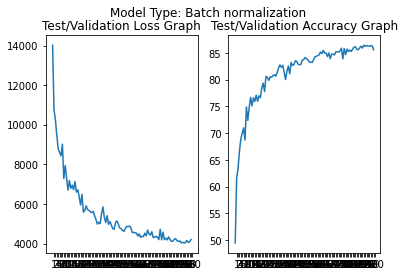

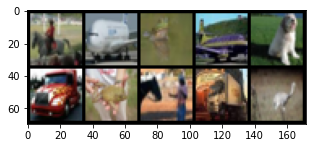

In [ ]:
test_10_images, test_10_images_target , test_10_pred_target = main(0,100)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


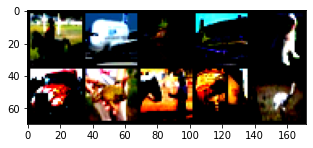

In [ ]:
  grid = torchvision.utils.make_grid(torch.stack(test_10_images).cpu(), nrow=5)
  plt.figure(figsize=(5,5))
  plt.imshow(np.transpose(grid, (1,2,0)))

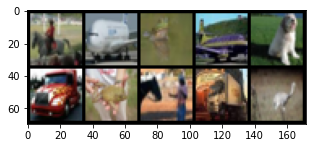

In [ ]:
test_10_images_unnorm = []
for img in test_10_images:
  img = img.cpu()
  img = img.numpy()
  img[0] = img[0] * 0.247 + 0.4914
  img[1] = img[1] * 0.2435 + 0.4822
  img[2] = img[2] * 0.2616 + 0.4465

  img = torch.from_numpy(img)
  test_10_images_unnorm.append(img)

grid = torchvision.utils.make_grid(torch.stack(test_10_images_unnorm).cpu(), nrow=5)
plt.figure(figsize=(5,5))
plt.imshow(np.transpose(grid, (1,2,0)))
  
